In [1]:
# coding = utf-8
"""
Created on Tue May  1 20:43:28 2018
@author: eesungkim
"""

import os
import math
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.special import jv

def bessel(v, X):
    return ((1j ** (-v)) * jv(v, 1j * X)).real


def stft(x, n_fft=512, win_length=400, hop_length=160, window='hamming'):
    if window == 'hanning':
        window = np.hanning(win_length)
    elif window == 'hamming':
        window = np.hamming(win_length)
    elif window == 'rectangle':
        window = np.ones(win_length)
    return np.array(
        [np.fft.rfft(window * x[i:i + win_length], n_fft, axis=0) for i in range(0, len(x) - win_length, hop_length)])


def estnoisem(pSpectrum, hop_length):
    (nFrames, nFFT2) = np.shape(pSpectrum)  # number of frames and freq bins
    x = np.array(np.zeros((nFrames, nFFT2)))  # initialize output arrays
    xs = np.array(np.zeros((nFrames, nFFT2)))  # will hold std error in the future

    # default algorithm constants
    taca = 0.0449  # smoothing time constant for alpha_c = -hop_length/log(0.7) in equ (11)
    tamax = 0.392  # max smoothing time constant in (3) = -hop_length/log(0.96)
    taminh = 0.0133  # min smoothing time constant (upper limit) in (3) = -hop_length/log(0.3)
    tpfall = 0.064  # time constant for P to fall (12)
    tbmax = 0.0717  # max smoothing time constant in (20) = -hop_length/log(0.8)
    qeqmin = 2.0  # minimum value of Qeq (23)
    qeqmax = 14.0  # max value of Qeq per frame
    av = 2.12  # fudge factor for bc calculation (23 + 13 lines)
    td = 1.536  # time to take minimum over
    nu = 8  # number of subwindows
    qith = np.array([0.03, 0.05, 0.06, np.Inf], dtype=float)  # noise slope thresholds in dB/s
    nsmdb = np.array([47, 31.4, 15.7, 4.1], dtype=float)  # maximum permitted +ve noise slope in dB/s

    # derived algorithm constants
    aca = np.exp(-hop_length / taca)  # smoothing constant for alpha_c in equ (11) = 0.7
    acmax = aca  # min value of alpha_c = 0.7 in equ (11) also = 0.7
    amax = np.exp(-hop_length / tamax)  # max smoothing constant in (3) = 0.96
    aminh = np.exp(-hop_length / taminh)  # min smoothing constant (upper limit) in (3) = 0.3
    bmax = np.exp(-hop_length / tbmax)  # max smoothing constant in (20) = 0.8
    SNRexp = -hop_length / tpfall
    nv = round(td / (hop_length * nu))  # length of each subwindow in frames

    if nv < 4:  # algorithm doesn't work for miniscule frames
        nv = 4
        nu = round(td / (hop_length * nv))
    nd = nu * nv  # length of total window in frames
    (md, hd, dd) = mhvals(nd)  # calculate the constants M(D) and H(D) from Table III
    (mv, hv, dv) = mhvals(nv)  # calculate the constants M(D) and H(D) from Table III
    nsms = np.array([10]) ** (nsmdb * nv * hop_length / 10)  # [8 4 2 1.2] in paper
    qeqimax = 1 / qeqmin  # maximum value of Qeq inverse (23)
    qeqimin = 1 / qeqmax  # minumum value of Qeq per frame inverse

    p = pSpectrum[0, :]  # smoothed power spectrum
    ac = 1  # correction factor (9)
    sn2 = p  # estimated noise power
    pb = p  # smoothed noisy speech power (20)
    pb2 = pb ** 2
    pminu = p
    actmin = np.array(np.ones(nFFT2) * np.Inf)  # Running minimum estimate
    actminsub = np.array(np.ones(nFFT2) * np.Inf)  # sub-window minimum estimate
    subwc = nv  # force a buffer switch on first loop
    actbuf = np.array(np.ones((nu, nFFT2)) * np.Inf)  # buffer to store subwindow minima
    ibuf = 0
    lminflag = np.zeros(nFFT2)  # flag to remember local minimum

    # loop for each frame
    for t in range(0, nFrames):  # we use t instead of lambda in the paper
        pSpectrum_t = pSpectrum[t, :]  # noise speech power spectrum
        acb = (1 + (sum(p) / sum(pSpectrum_t) - 1) ** 2) ** (-1)  # alpha_c-bar(t)  (9)

        tmp = np.array([acb])
        tmp[tmp < acmax] = acmax
        # max_complex(np.array([acb] ),np.array([acmax] ))
        ac = aca * ac + (1 - aca) * tmp  # alpha_c(t)  (10)
        ah = amax * ac * (1 + (p / sn2 - 1) ** 2) ** (-1)  # alpha_hat: smoothing factor per frequency (11)
        SNR = sum(p) / sum(sn2)
        ah = max_complex(ah,
                         min_complex(np.array([aminh]), np.array([SNR ** SNRexp])))  # lower limit for alpha_hat (12)
        p = ah * p + (1 - ah) * pSpectrum_t  # smoothed noisy speech power (3)
        b = min_complex(ah ** 2,
                        np.array([bmax]))  # smoothing constant for estimating periodogram variance (22 + 2 lines)
        pb = b * pb + (1 - b) * p  # smoothed periodogram (20)
        pb2 = b * pb2 + (1 - b) * p ** 2  # smoothed periodogram squared (21)
        qeqi = max_complex(min_complex((pb2 - pb ** 2) / (2 * sn2 ** 2), np.array([qeqimax])),
                           np.array([qeqimin / (t + 1)]))  # Qeq inverse (23)
        qiav = sum(
            qeqi) / nFFT2  # Average over all frequencies (23+12 lines) (ignore non-duplication of DC and nyquist terms)
        bc = 1 + av * np.sqrt(qiav)  # bias correction factor (23+11 lines)
        bmind = 1 + 2 * (nd - 1) * (1 - md) / (
                    qeqi ** (-1) - 2 * md)  # we use the signalmplified form (17) instead of (15)
        bminv = 1 + 2 * (nv - 1) * (1 - mv) / (qeqi ** (-1) - 2 * mv)  # same expressignalon but for sub windows
        kmod = (bc * p * bmind) < actmin  # Frequency mask for new minimum

        if any(kmod):
            actmin[kmod] = bc * p[kmod] * bmind[kmod]
            actminsub[kmod] = bc * p[kmod] * bminv[kmod]

        if subwc > 1 and subwc < nv:  # middle of buffer - allow a local minimum
            lminflag = np.logical_or(lminflag, kmod)  # potential local minimum frequency bins
            pminu = min_complex(actminsub, pminu)
            sn2 = pminu.copy()
        else:
            if subwc >= nv:  # end of buffer - do a buffer switch
                ibuf = 1 + (ibuf % nu)  # increment actbuf storage pointer
                actbuf[ibuf - 1, :] = actmin.copy()  # save sub-window minimum
                pminu = min_complex_mat(actbuf)
                i = np.nonzero(np.array(qiav) < qith)
                nsm = nsms[i[0][0]]  # noise slope max
                lmin = np.logical_and(
                    np.logical_and(np.logical_and(lminflag, np.logical_not(kmod)), actminsub < (nsm * pminu)),
                    actminsub > pminu)
                if any(lmin):
                    pminu[lmin] = actminsub[lmin]
                    actbuf[:, lmin] = np.ones((nu, 1)) * pminu[lmin]
                lminflag[:] = 0
                actmin[:] = np.Inf
                subwc = 0
        subwc = subwc + 1
        x[t, :] = sn2.copy()
        qisq = np.sqrt(qeqi)
        # empirical formula for standard error based on Fig 15 of [2]
        xs[t, :] = sn2 * np.sqrt(
            0.266 * (nd + 100 * qisq) * qisq / (1 + 0.005 * nd + 6 / nd) / (0.5 * qeqi ** (-1) + nd - 1))

    return x


def mhvals(*args):
    nargin = len(args)

    dmh = np.array([
        [1, 0, 0],
        [2, 0.26, 0.15],
        [5, 0.48, 0.48],
        [8, 0.58, 0.78],
        [10, 0.61, 0.98],
        [15, 0.668, 1.55],
        [20, 0.705, 2],
        [30, 0.762, 2.3],
        [40, 0.8, 2.52],
        [60, 0.841, 3.1],
        [80, 0.865, 3.38],
        [120, 0.89, 4.15],
        [140, 0.9, 4.35],
        [160, 0.91, 4.25],
        [180, 0.92, 3.9],
        [220, 0.93, 4.1],
        [260, 0.935, 4.7],
        [300, 0.94, 5]
    ], dtype=float)

    if nargin >= 1:
        d = args[0]
        i = np.nonzero(d <= dmh[:, 0])
        if len(i) == 0:
            i = np.shape(dmh)[0] - 1
            j = i
        else:
            i = i[0][0]
            j = i - 1
        if d == dmh[i, 0]:
            m = dmh[i, 1]
            h = dmh[i, 2]
        else:
            qj = np.sqrt(dmh[i - 1, 0])  # interpolate usignalng sqrt(d)
            qi = np.sqrt(dmh[i, 0])
            q = np.sqrt(d)
            h = dmh[i, 2] + (q - qi) * (dmh[j, 2] - dmh[i, 2]) / (qj - qi)
            m = dmh[i, 1] + (qi * qj / q - qj) * (dmh[j, 1] - dmh[i, 1]) / (qi - qj)
    else:
        d = dmh[:, 0].copy()
        m = dmh[:, 1].copy()
        h = dmh[:, 2].copy()

    return m, h, d


def max_complex(a, b):
    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])
    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa > bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex(a, b):

    if len(a) == 1 and len(b) > 1:
        a = np.tile(a, np.shape(b))
    if len(b) == 1 and len(a) > 1:
        b = np.tile(b, np.shape(a))

    i = np.logical_or(np.iscomplex(a), np.iscomplex(b))

    aa = a.copy()
    bb = b.copy()

    if any(i):
        aa[i] = np.absolute(aa[i])
        bb[i] = np.absolute(bb[i])

    if a.dtype == 'complex' or b.dtype == 'complex':
        cc = np.array(np.zeros(np.shape(a)))
    else:
        cc = np.array(np.zeros(np.shape(a)), dtype=float)

    i = aa < bb
    cc[i] = a[i]
    cc[np.logical_not(i)] = b[np.logical_not(i)]

    return cc


def min_complex_mat(a):
    s = np.shape(a)
    m = np.array(np.zeros(s[1]))
    for i in range(0, s[1]):
        j = np.argmin(np.absolute(a[:, i]))
        m[i] = a[j, i]
    return m


def VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.7):
    """Voice Activity Detector
    J. Sohn, N. S. Kim, and W. Sung. "A statistical model-based voice activity detection," IEEE Signal Processing Letters, Vol. 6, issue 1, pp. 1-3, Jan. 1999.
    Parameters
    ----------
    signal      : audio time series
    sr    		: sampling rate of `signal`
    nFFT     	: length of the FFT window
    win_length 	: window size in sec
    hop_length 	: hop size in sec
    Returns
    -------
    probRatio   : frame-based voice activity probability sequence
    """
    signal = signal.astype('float')

    maxPosteriorSNR = 100
    minPosteriorSNR = 0.0001

    win_length_sample = round(win_length * sr)
    hop_length_sample = round(hop_length * sr)

    # the variance of the speech; lambda_x(k)
    _stft = stft(signal, n_fft=nFFT, win_length=win_length_sample, hop_length=hop_length_sample)
    pSpectrum = np.abs(_stft) ** 2

    # estimate the variance of the noise using minimum statistics noise PSD estimation ; lambda_d(k).
    estNoise = estnoisem(pSpectrum, hop_length)
    estNoise = estNoise

    aPosterioriSNR = pSpectrum / estNoise
    aPosterioriSNR = aPosterioriSNR
    aPosterioriSNR[aPosterioriSNR > maxPosteriorSNR] = maxPosteriorSNR
    aPosterioriSNR[aPosterioriSNR < minPosteriorSNR] = minPosteriorSNR

    a01 = hop_length / 0.05  # a01=P(signallence->speech)  hop_length/mean signallence length (50 ms)
    a00 = 1 - a01  # a00=P(signallence->signallence)
    a10 = hop_length / 0.1  # a10=P(speech->signallence) hop/mean talkspurt length (100 ms)
    a11 = 1 - a10  # a11=P(speech->speech)

    b01 = a01 / a00
    b10 = a11 - a10 * a01 / a00

    smoothFactorDD = 0.99
    previousGainedaPosSNR = 1
    (nFrames, nFFT2) = pSpectrum.shape
    probRatio = np.zeros((nFrames, 1))
    logGamma_frame = 0
    for i in range(nFrames):
        aPosterioriSNR_frame = aPosterioriSNR[i, :]

        # operator [2](52)
        oper = aPosterioriSNR_frame - 1
        oper[oper < 0] = 0
        smoothed_a_priori_SNR = smoothFactorDD * previousGainedaPosSNR + (1 - smoothFactorDD) * oper

        # V for MMSE estimate ([2](8))
        V = 0.1 * smoothed_a_priori_SNR * aPosterioriSNR_frame / (1 + smoothed_a_priori_SNR)

        # geometric mean of log likelihood ratios for individual frequency band  [1](4)
        logLRforFreqBins = 2 * V - np.log(smoothed_a_priori_SNR + 1)
        # logLRforFreqBins=np.exp(smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR))/(1+smoothed_a_priori_SNR)
        gMeanLogLRT = np.mean(logLRforFreqBins)
        logGamma_frame = np.log(a10 / a01) + gMeanLogLRT + np.log(b01 + b10 / (a10 + a00 * np.exp(-logGamma_frame)))
        probRatio[i] = 1 / (1 + np.exp(-logGamma_frame))

        # Calculate Gain function which results from the MMSE [2](7).
        gain = (math.gamma(1.5) * np.sqrt(V)) / aPosterioriSNR_frame * np.exp(-1 * V / 2) * (
                    (1 + V) * bessel(0, V / 2) + V * bessel(1, V / 2))

        previousGainedaPosSNR = (gain ** 2) * aPosterioriSNR_frame
        probRatio[probRatio > theshold] = 1
        probRatio[probRatio < theshold] = 0

    arr = []
    for idx, frame in enumerate(probRatio):
        if idx == 1:
            for _ in range(int(sr * (win_length - hop_length))):
                arr.append(frame[0])
            continue;
        for _ in range(int(sr * hop_length)):
            arr.append(frame[0])
    l = len(signal) - len(arr)
    return (arr + [0] * l)[:len(signal)]


/Users/kakao/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


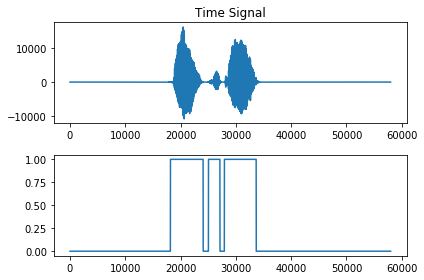

In [7]:

path_clean = 'datasets/SI1265_FJWB0_2.wav'

path_wav = os.path.join(os.getcwd() , path_clean )
(sr, signal) = wav.read(path_wav)

vad=VAD(signal, sr, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.99)

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Time Signal')

plt.subplot(2, 1, 2)
plt.plot(vad)


plt.tight_layout()
plt.show()
